# Lab 04 : VGG architecture - exercise

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # find automatically the path of the folder containing "file_name" :
    file_name = 'vgg_exercise.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    # if previous search failed or too long, comment the previous line and simply write down manually the path below :
    #path_to_file = '/content/gdrive/My Drive/AI6103_2020_codes/codes/labs_lecture08/lab04_vgg'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time
from IPython.core.debugger import set_trace

### With or without GPU?

It is recommended to run this code on GPU:<br> 
* Time for 1 epoch on CPU : 841 sec (14.02 min)<br> 
* Time for 1 epoch on GPU : 9 sec w/ GeForce GTX 1080 Ti <br>

In [3]:
device= torch.device("cuda")
# device= torch.device("cpu")
print(device)

cuda


### Download the CIFAR dataset 

In [16]:
from utils import check_cifar_dataset_exists
data_path=check_cifar_dataset_exists()

train_data=torch.load(data_path+'cifar/train_data.pt')
train_label=torch.load(data_path+'cifar/train_label.pt')
test_data=torch.load(data_path+'cifar/test_data.pt')
test_label=torch.load(data_path+'cifar/test_label.pt')

print(train_data.size())
print(test_data.size())

torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


### Compute mean pixel intensity over all training set and all channels

In [17]:
mean= train_data.mean()

print(mean)

tensor(0.4735)


### Compute standard deviation

In [18]:
std= train_data.std()

print(std)

tensor(0.2516)


### Make a VGG convnet class. 

In [31]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1) # COMPLETE HERE
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1) # COMPLETE HERE
        self.pool2  = nn.MaxPool2d(2,2) # COMPLETE HERE

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1) # COMPLETE HERE
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1) # COMPLETE HERE
        self.pool3  = nn.MaxPool2d(2,2) # COMPLETE HERE
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1) # COMPLETE HERE
        self.pool4  = nn.MaxPool2d(2,2) # COMPLETE HERE

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096) # COMPLETE HERE
        self.linear2 = nn.Linear(4096, 4096) # COMPLETE HERE
        self.linear3 = nn.Linear(4096, 10) # COMPLETE HERE


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x) # COMPLETE HERE
        x = F.relu(x) # COMPLETE HERE
        x = self.conv2b(x) # COMPLETE HERE
        x = F.relu(x) # COMPLETE HERE
        x = self.pool2(x) # COMPLETE HERE

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x) # COMPLETE HERE
        x = F.relu(x) # COMPLETE HERE
        x = self.conv3b(x) # COMPLETE HERE
        x = F.relu(x) # COMPLETE HERE
        x = self.pool3(x) # COMPLETE HERE

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x) # COMPLETE HERE
        x = F.relu(x) # COMPLETE HERE
        x = self.pool4(x) # COMPLETE HERE

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x) # COMPLETE HERE
        x = F.relu(x) # COMPLETE HERE
        x = self.linear2(x) # COMPLETE HERE
        x = F.relu(x) # COMPLETE HERE
        x = self.linear3(x) # COMPLETE HERE 
        
        return x

### Build the net. How many parameters in total? (the three layer net had 2 million parameters)

In [32]:
net =VGG_convnet() # COMPLETE HERE

print(net)
utils.display_num_param(net)

VGG_convnet(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(i

### Send the weights of the networks to the GPU (as well as the mean and std)

In [33]:
net = net.to(device) # COMPLETE HERE

mean = mean.to(device)

std = std.to(device)

### Choose the criterion, batch size, and initial learning rate. Select the following:
* batch size =128
* initial learning rate =0.25


In [34]:
criterion = nn.CrossEntropyLoss()
my_lr= 0.25 # COMPLETE HERE
bs= 128   # COMPLETE HERE

### Function to evaluate the network on the test set

In [35]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std

        scores=net( inputs ) 

        error = utils.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

### Do 20 passes through the training set. Divide the learning rate by 2 at epoch 10, 14 and 18.

In [36]:
start=time.time()

for epoch in range(1,20):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch == 10 or epoch == 14 or epoch == 18: # COMPLETE HERE
        my_lr = my_lr/ 2 # COMPLETE HERE
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        inputs = (minibatch_data - mean)/std
        
#         set_trace()
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    
           

epoch= 1 	 time= 0.3316066185633341 min 	 lr= 0.25 	 loss= 2.2853654784619657 	 error= 87.92798912433713 percent
error rate on test set = 79.22270569620254 percent
 
epoch= 2 	 time= 0.6601565519968668 min 	 lr= 0.25 	 loss= 1.9420985001737199 	 error= 73.70364449518111 percent
error rate on test set = 74.5253164556962 percent
 
epoch= 3 	 time= 1.0000557939211527 min 	 lr= 0.25 	 loss= 1.644527381948193 	 error= 61.36189257092488 percent
error rate on test set = 60.49248417721519 percent
 
epoch= 4 	 time= 1.3524559378623962 min 	 lr= 0.25 	 loss= 1.3412955778334148 	 error= 48.51542519181586 percent
error rate on test set = 41.30735759493671 percent
 
epoch= 5 	 time= 1.7128807703653972 min 	 lr= 0.25 	 loss= 1.0562288883092152 	 error= 37.64546034890977 percent
error rate on test set = 40.664556962025316 percent
 
epoch= 6 	 time= 2.0687700867652894 min 	 lr= 0.25 	 loss= 0.8489272390180231 	 error= 29.653532608695656 percent
error rate on test set = 32.20925632911392 percent
 
epoc

### Choose image at random from the test set and see how good/bad are the predictions

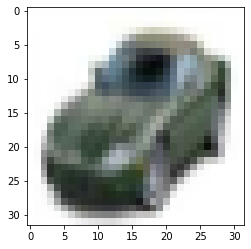

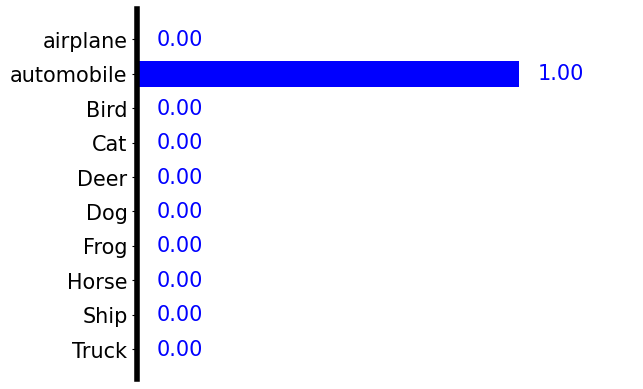

In [37]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im= (im-mean) / std
im=im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
utils.show_prob_cifar(probs.cpu())